In [3]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 3a - Coupled 2-box with vertical diffusion

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [107]:
# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 2

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, exp in enumerate(experiments):
  full_outputs[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i,vert_diff_flag=1)
  forcings[exp] = np.tile(full_outputs[exp]['forcing_ts'], (n_boxes, 1))
  T_out[exp] = np.squeeze(full_outputs[exp]['T_ts'])[0:n_boxes,:]

100%|██████████| 365239/365239 [00:05<00:00, 66010.30it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:299: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  grid['dz_slabs'] = np.array([1500, 10, 150, 10, 1500])  # Water slabs thickness [m]
100%|██████████| 365239/365239 [00:06<00:00, 60414.85it/s]


In [124]:
for exp in experiments:
  forcings[exp][1] = np.zeros(len(forcings[exp][1]))

### Method X: DMD

In [127]:
A,B = operator_DMD['2xCO2']

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.0007320307812589514
	Test: High Emissions - 0.8947699768345785
	Test: Overshoot - 0.18659193697005785
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.7660643193311003
	Test: High Emissions - 1.1420751500895988e-05
	Test: Overshoot - 0.791860133512161
Train: Overshoot - L2 Error
	Test: 2xCO2 - 0.3970797016601347
	Test: High Emissions - 0.5990848828777026
	Test: Overshoot - 0.00479944196297503


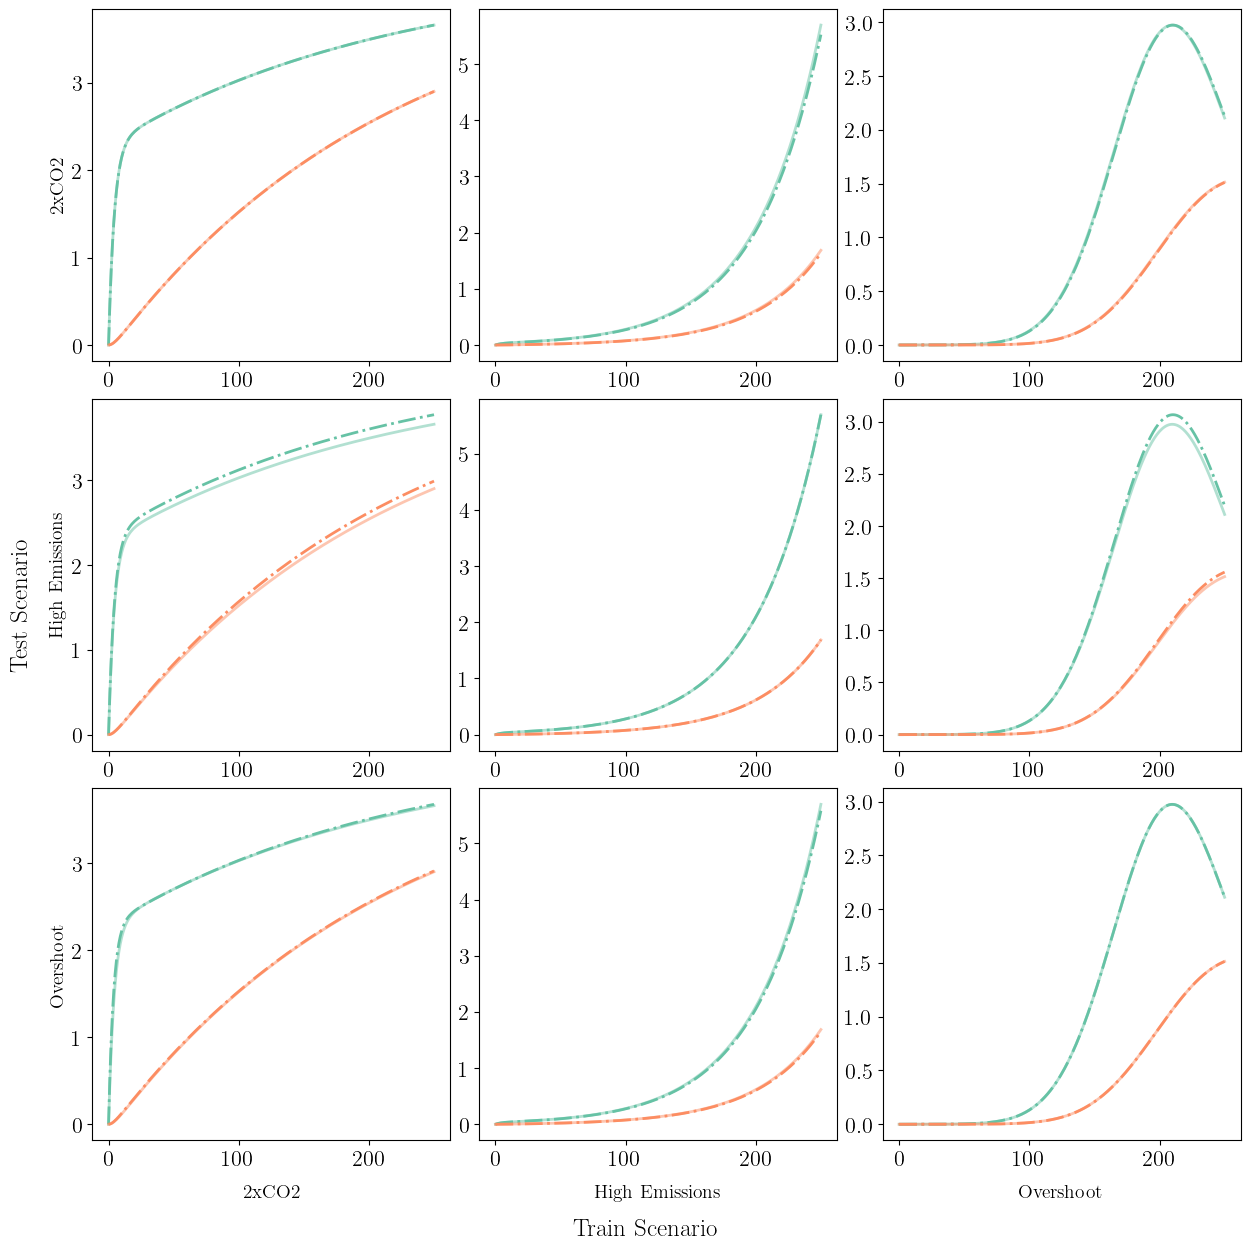

In [126]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_DMD, T_pred_DMD = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'DMD', w0, t, dt, n_steps, n_boxes)
emulator_utils.plot_true_pred(T_out, T_pred_DMD, experiments)

### Method X: EDMD

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.0006694284467059111
	Test: High Emissions - 2.8279702812448226
	Test: Overshoot - 2.704885999942558
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.784117235211878
	Test: High Emissions - 2.290230561763539e-05
	Test: Overshoot - 0.790343035690092
Train: Overshoot - L2 Error
	Test: 2xCO2 - 0.5064034303080819
	Test: High Emissions - 0.5946935616195355
	Test: Overshoot - 0.003326597120141108


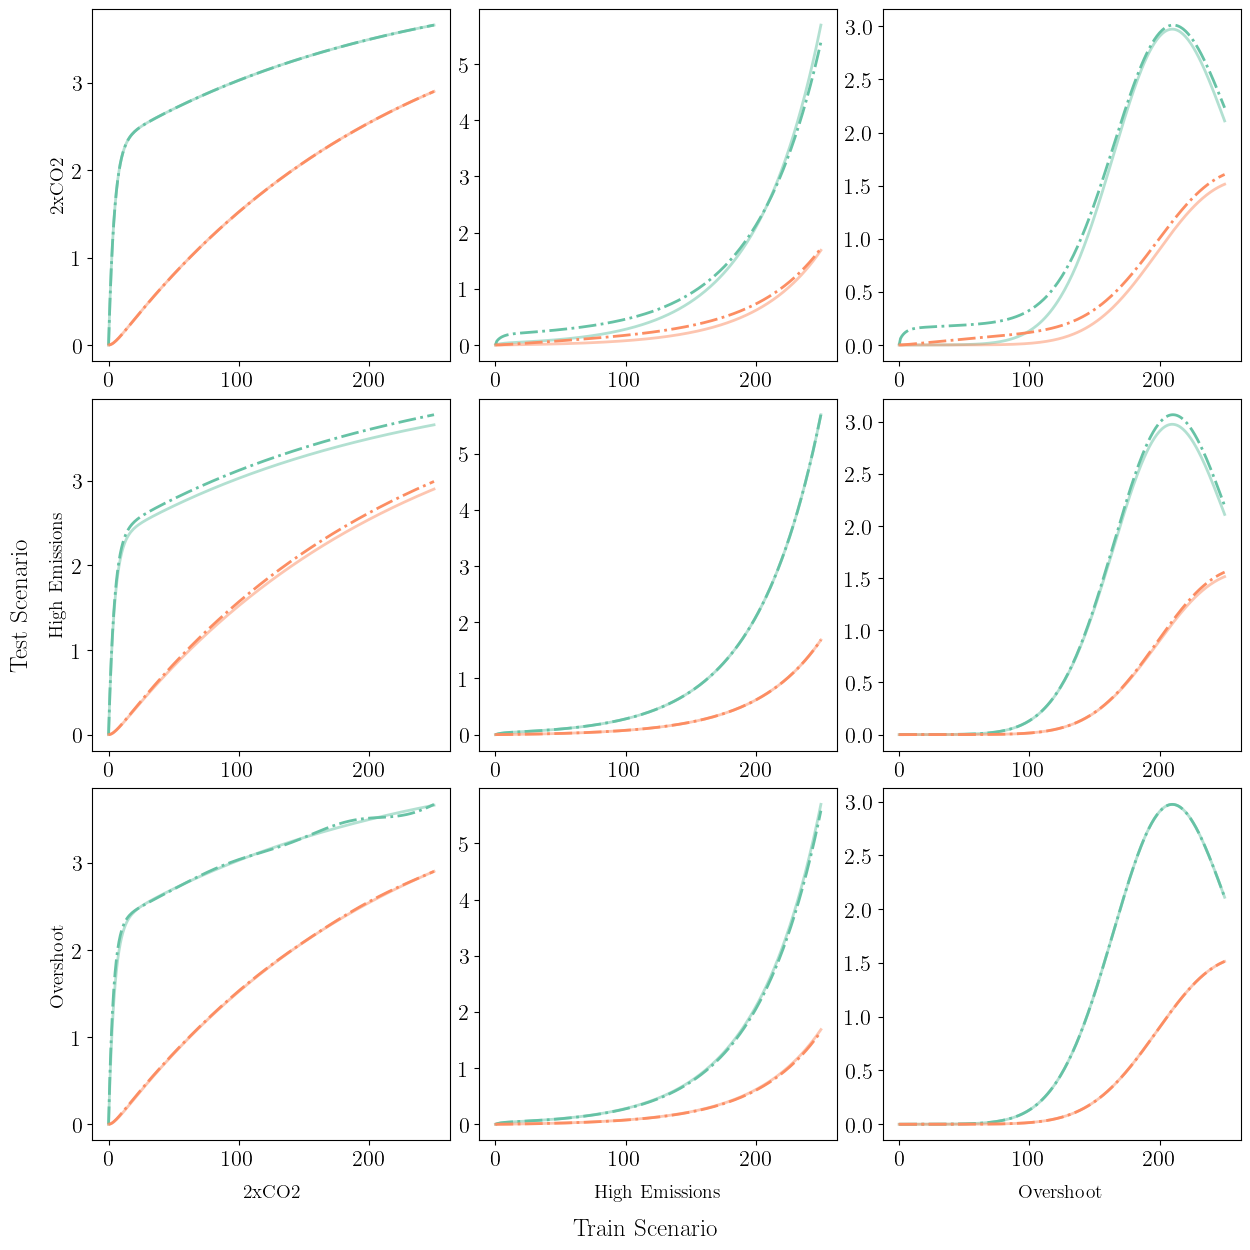

In [130]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=1)
operator_EDMD, T_pred_EDMD = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'EDMD', w0, t, dt, n_steps, n_boxes, w_dict, F_dict)
emulator_utils.plot_true_pred(T_out, T_pred_EDMD, experiments)

### Method X: Deconvolution

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 8.39933049553625e-15
	Test: High Emissions - 0.8942535551507004
	Test: Overshoot - 0.18622757491498976
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.7652366227496572
	Test: High Emissions - 2.0228257990744968e-14
	Test: Overshoot - 0.7913046848521267
Train: Overshoot - L2 Error
	Test: 2xCO2 - 412219.5459765136
	Test: High Emissions - 6549.419191255319
	Test: Overshoot - 2.899398777466767e-14


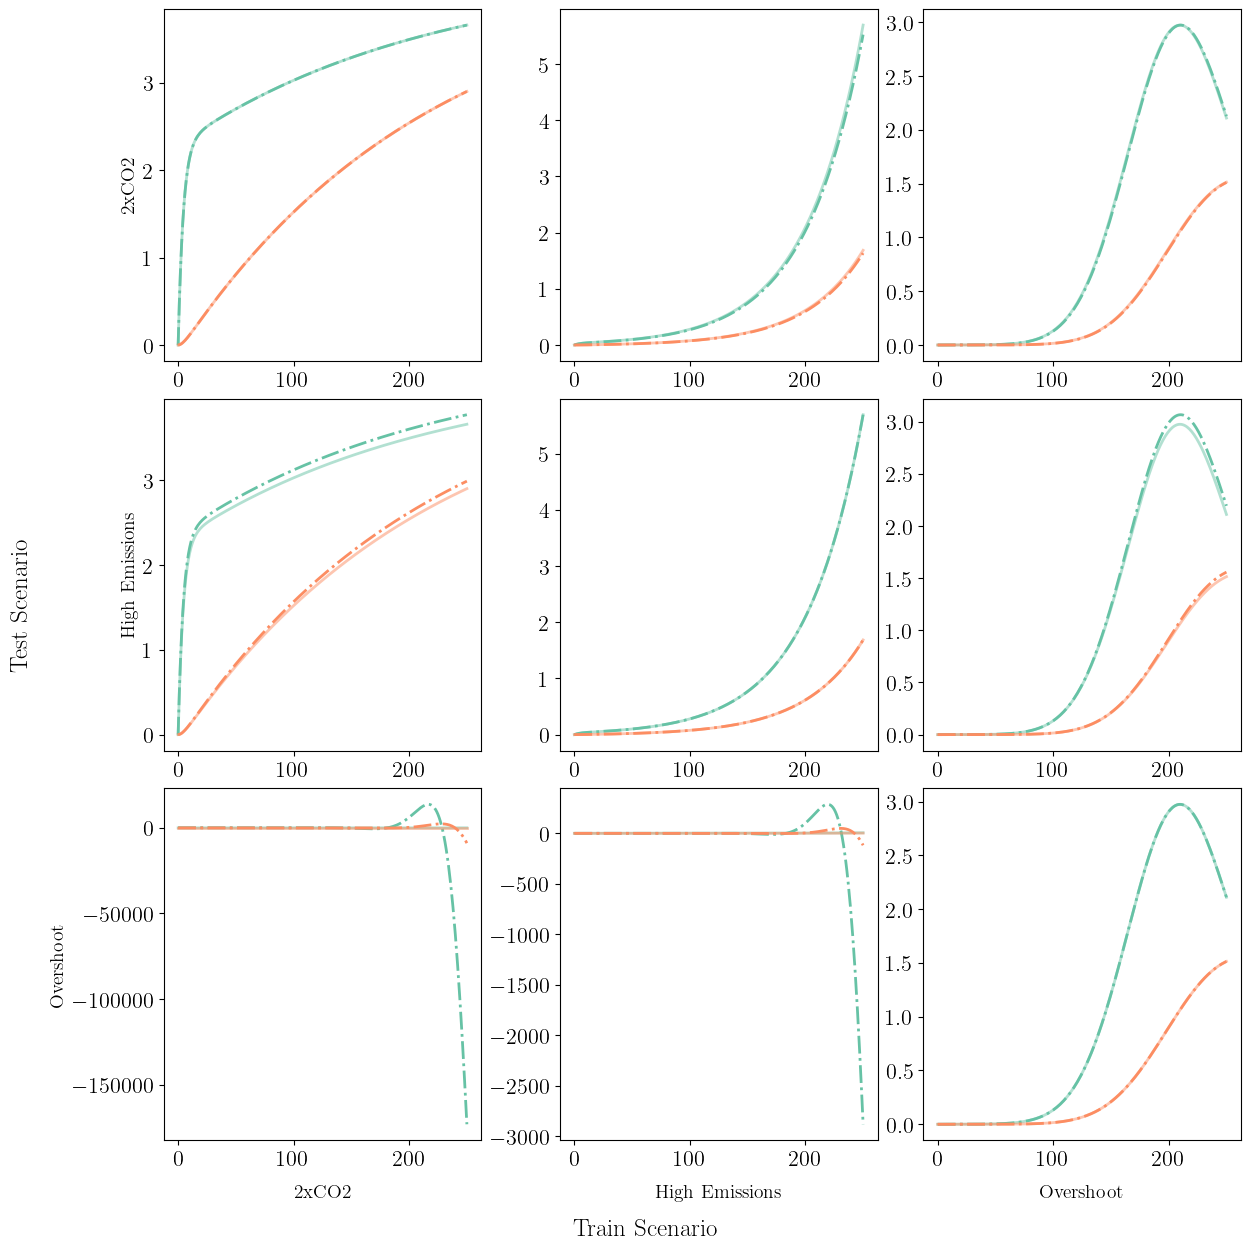

In [131]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'deconvolve', w0, t, dt, n_steps, n_boxes)
emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)

### Method X: Direct Diagnosis (FDT)

100%|██████████| 365239/365239 [00:05<00:00, 67680.59it/s]


Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 0.005721946699657816
	Test: High Emissions - 0.8903818961309823
	Test: Overshoot - 0.18511695512292664


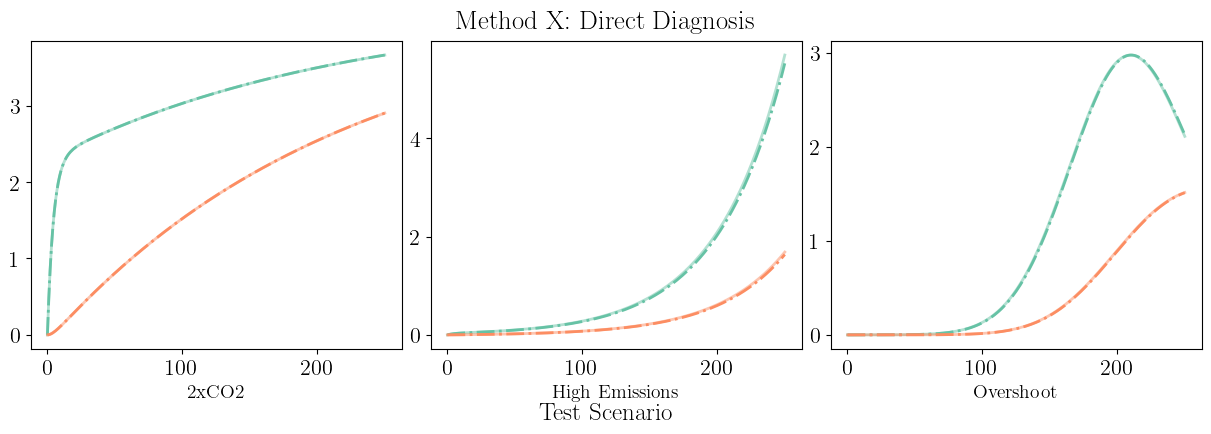

In [115]:
operator_direct, T_pred_direct = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'direct', w0, t, dt, n_steps, n_boxes, vert_diff_flag=1)
emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [ 0.5636958   0.39960492 -0.00294101  0.74566847 -0.99627297 -0.00446863]
	Test: 2xCO2 - 2.2058598326210728
	Test: High Emissions - 0.29559612183917644
	Test: Overshoot - 0.8131601208684512
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.7160171   0.64643324  0.50710256 -2.2682105  -0.83465376 -1.2354605 ]
	Test: 2xCO2 - 22.239134038800238
	Test: High Emissions - 0.13195308078342752
	Test: Overshoot - 5.690631935597779
Train: Overshoot - L2 Error
Exponential Fit Results:
 [-5.45969057e+02 -6.57386505e+02  3.69119260e+02  6.51290178e+02
 -6.86816558e-01 -6.30948158e-01]
	Test: 2xCO2 - 19.583458024997356
	Test: High Emissions - 2.5847908171773786
	Test: Overshoot - 5.1948820809057725


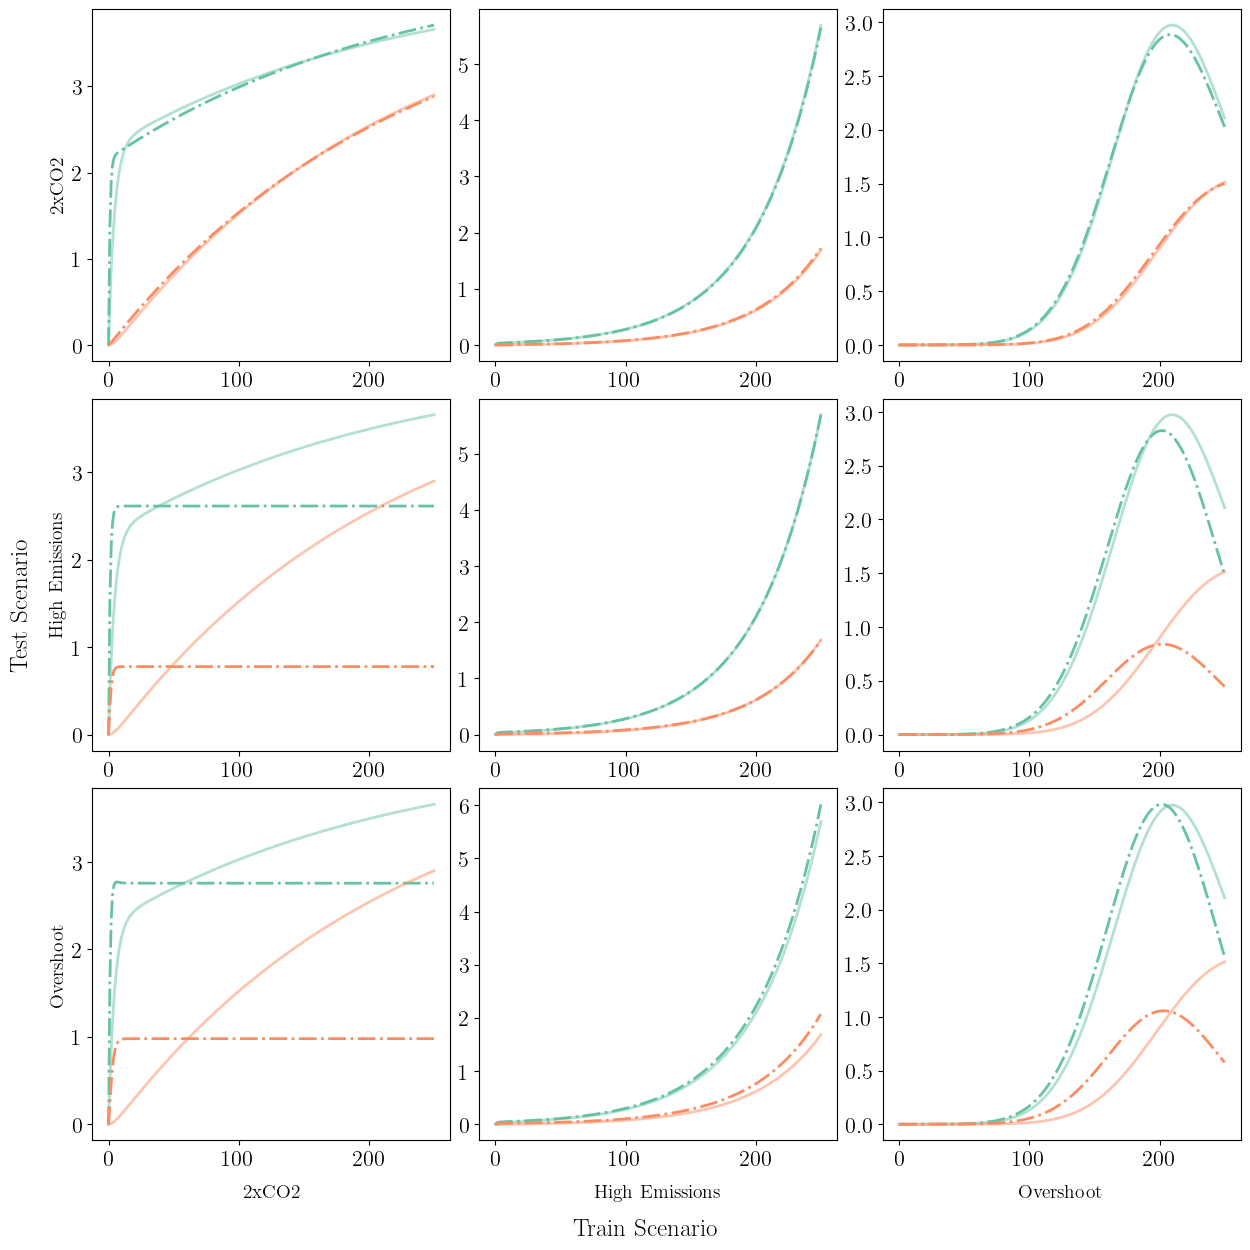

In [132]:
B=np.array([1.0, 0.0])
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2, B=B)
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)